<a href="https://colab.research.google.com/github/donggrant/sign-language-interface/blob/master/model_development_imageset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip
!unzip Dataset.zip

--2022-04-17 16:03:08--  https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/master/Dataset.zip [following]
--2022-04-17 16:03:09--  https://raw.githubusercontent.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/master/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33742153 (32M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  32.18M  89.2MB/s    in 0.4s 

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image).reshape((im_height, im_width, 1)).astype(np.uint8)

In [ ]:
path = 'Dataset/'
list_of_files = list(filter(lambda f: '.jpg' in f[0],[ (file, os.sep.join((dir, file)))
                       for (dir,dirs,files) in os.walk(path)
                       for file in files]))

In [ ]:
from keras.preprocessing.image import load_img
X = np.asarray(list(map(lambda k: np.asarray(Image.open(k[1])), list_of_files)))
y = np.asarray(list(map(lambda k: k[0][:1], list_of_files)))

In [ ]:
def augment(image, lab):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.5, 1)
  image = tf.keras.preprocessing.image.random_rotation(image, 20, row_axis=1,col_axis=2,channel_axis=0,
    fill_mode='nearest',cval=0.0,interpolation_order=1)
  image = tf.keras.preprocessing.image.random_shear(image, 20,row_axis=1,col_axis=2,channel_axis=0,
    fill_mode='nearest',cval=0.0,interpolation_order=1)
  return (image, lab)

tup_list = list(
    map(
        lambda tup: [augment(tup[0], tup[1]) for i in range(5)],
        zip(X, y)
        )
    )

In [ ]:
from pipey import Pipeable

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]
y_bin = le.fit(class_names)
y = y_bin.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.2, random_state = 12345)
X_test, X_eval, y_test, y_eval= train_test_split(X_validate, y_validate, test_size = 0.5, random_state = 12345)

In [ ]:
y_train.shape

(1344,)

In [ ]:
X_train.shape

(1344, 240, 320, 3)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard


#Defining the Convolutional Neural Network
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), input_shape = (240,320,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 512, activation = 'relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(units = 24, activation = 'softmax'))

In [ ]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 238, 318, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 119, 159, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 119, 159, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 78, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 58, 78, 64)       

In [ ]:
history = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 20, verbose = 1, validation_data = (X_eval, y_eval))

Epoch 1/20
42/42 [==============================] - 10s 209ms/step - loss: 365.7214 - accuracy: 0.0469 - val_loss: 3.1785 - val_accuracy: 0.0476
Epoch 2/20
42/42 [==============================] - 8s 200ms/step - loss: 3.0700 - accuracy: 0.0990 - val_loss: 2.7912 - val_accuracy: 0.2083
Epoch 3/20
42/42 [==============================] - 8s 200ms/step - loss: 2.7051 - accuracy: 0.2366 - val_loss: 2.3163 - val_accuracy: 0.3333
Epoch 4/20
42/42 [==============================] - 8s 200ms/step - loss: 2.2824 - accuracy: 0.3400 - val_loss: 2.0138 - val_accuracy: 0.3988
Epoch 5/20
42/42 [==============================] - 8s 200ms/step - loss: 1.7806 - accuracy: 0.5007 - val_loss: 1.4014 - val_accuracy: 0.6012
Epoch 6/20
42/42 [==============================] - 8s 201ms/step - loss: 1.3241 - accuracy: 0.6153 - val_loss: 0.9157 - val_accuracy: 0.7619
Epoch 7/20
42/42 [==============================] - 8s 200ms/step - loss: 0.9173 - accuracy: 0.7426 - val_loss: 0.8851 - val_accuracy: 0.7798
Epo

In [ ]:
predict_x = cnn_model.predict(X_eval) 
predicted_classes = np.argmax(predict_x,axis=1)

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_eval, predicted_classes)
print('Eval Accuracy Score = ',acc_score)

predict_x = cnn_model.predict(X_test) 
predicted_classes = np.argmax(predict_x,axis=1)

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, predicted_classes)
print('Test Accuracy Score = ',acc_score)

Eval Accuracy Score =  0.9166666666666666
Test Accuracy Score =  0.9047619047619048


Confusion matrix, without normalization


<Figure size 1440x1440 with 0 Axes>

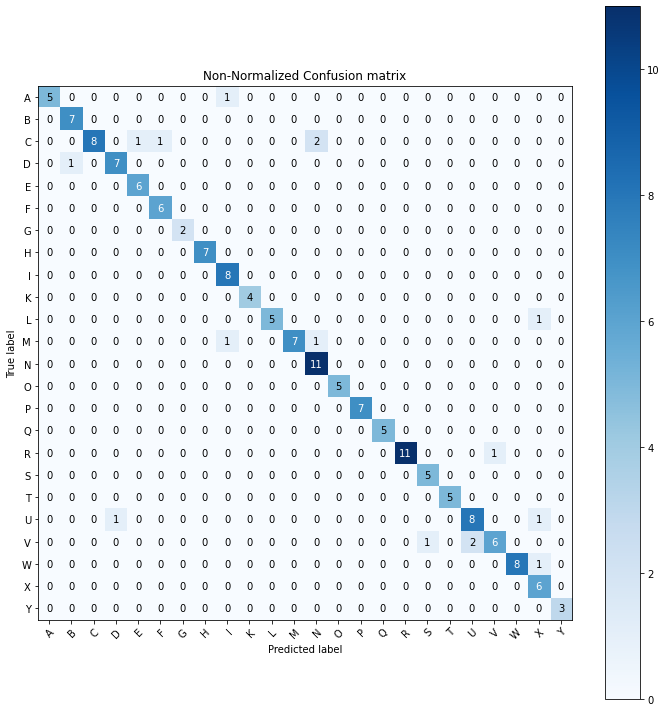

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, predicted_classes)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, predicted_classes, classes = class_names, title='Non-Normalized Confusion matrix')
plt.show()

Camera Test

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


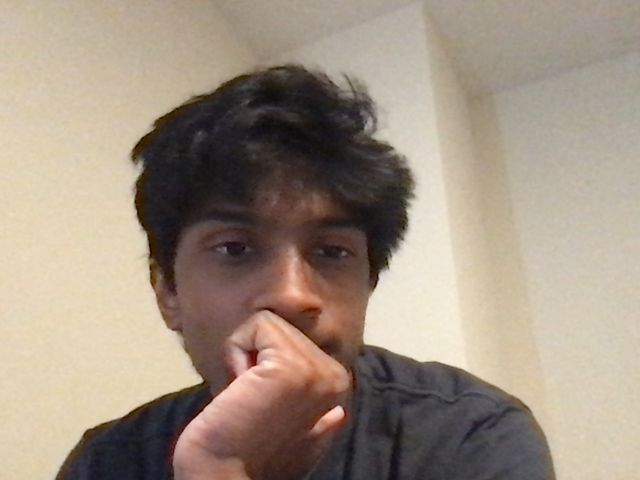

Y

In [ ]:
from IPython.display import Image
import numpy as np
import cv2

try:
  filename = '/content/l1.jpeg'
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
  
from PIL import Image
# Preprocess image for model
img = Image.open(filename)
img = np.asarray(img)
img = cv2.resize(img,(240,320))  
img = img.reshape(1,240,320,3)
output = cnn_model.predict(img)[0]
sign = class_names[np.argmax(output)]
print(sign, end="")